# Curve separation


In this notebook we will look at some basics of separating a given curve into underlying simpler component Gaussian curves. First lets generate a curve using multiple gaussians, add some noise to it, to simulate some real world data

In [114]:
pip install numpy matplotlib scipy scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 29.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 17.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Simulated data generation

In this section we assume that the underlying data consists of 3 Gaussian curves `curve0`, `curve1` and `curve2`. They are combined using different weights to get the orange `curve without noise`, and finally we measure that (with noise) to getthe blue samples of `simulated` data (`x_final`, `y_final`)

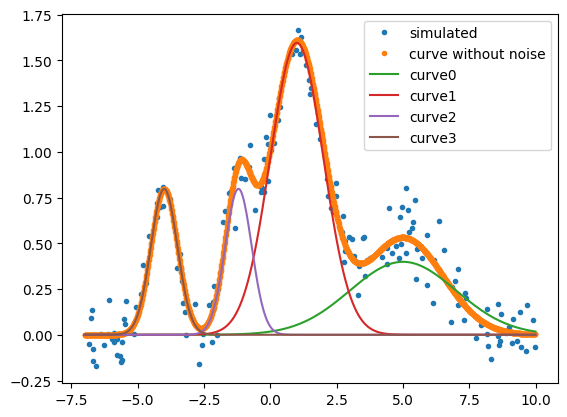

In [221]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(100)

def gaussian(x, mu, sig):
    return (1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2))

# accepts parameters of the underlying "ground truth" gaussian curves, and return a mixed curve function
def curve_generator(means, stds, wts):
    assert len(means) == len(stds) == len(wts)
    def curve(x):
        return sum(wt * gaussian(x, mn, std) for mn, std, wt in zip(means, stds, wts))
    return curve

def sample(x, y, p):
    assert len(x) == len(y)
    idxs = [np.random.random()<p for i in range(len(x))]
    return x[idxs], y[idxs]
    

def add_noise(y):
    return y + 0.1*np.random.normal(0,1,len(y))


combo_curve = curve_generator([5, 1.0, -1.2, -4], [1.5, 1, 0.5, 0.5], [2, 4, 1, 1])
curve0 = curve_generator([5], [2], [2])
curve1 = curve_generator([1.0], [1], [4])
curve2 = curve_generator([-1.2], [0.5], [1])
curve3 = curve_generator([-4], [0.5], [1])


x = np.arange(-7, 10, 0.01)
y = np.array([combo_curve(i) for i in x])
y_noise = add_noise(y)

x_final, y_final = sample(x, y_noise, 0.1)

def plot_helper_single_curve(curve_fn, x, tag):
    y0 = np.array([curve_fn(i) for i in x])
    plt.plot(x,y0, label=tag)

def plot_helper():    
    plt.plot(x_final, y_final, '.', label="simulated")
    plt.plot(x, y, '.', label="curve without noise")
    

    plot_helper_single_curve(curve0, x, "curve0")
    plot_helper_single_curve(curve1, x, "curve1")
    plot_helper_single_curve(curve2, x, "curve2")
    plot_helper_single_curve(curve3, x, "curve3")

plot_helper()
plt.legend()
plt.show()
    

Now our goal is to disentangle the observed/measured data and try to guess the original underlying curves.

## Known peaks

Let us assume that we have an initial estimate of the peaks

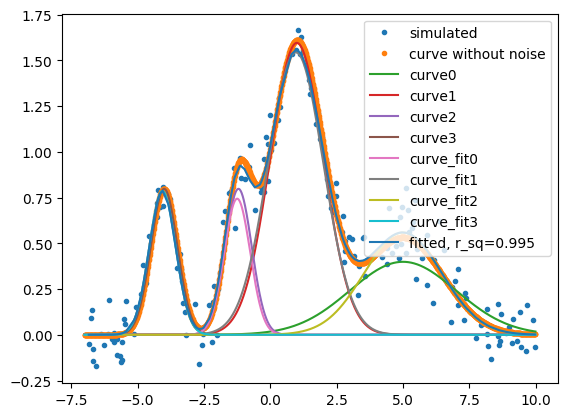

r squared value = 0.995
[-1.24785317  0.49147849  0.91655083  0.96349016  1.03656629  4.0122596
  4.99937456  1.45649553  2.0400405  -4.06206382  0.50035178  0.98579649]


In [222]:

from scipy.optimize import curve_fit


#def curve_to_fit(x, m0, std0, wt0, m1, std1, wt1, m2, std2, wt2):
#    return wt0*gaussian(x, m0, std0) + wt1*gaussian(x, m1, std1) + wt2*gaussian(x, m2, std2)
# create_curve_to_fit generalizes above function.
# It creates a function that accepts "n" that will return this function that accepts 3n+1 args
def create_curve_to_fit(n):
    fn_str = 'lambda x, '
    for i in range(n):
        fn_str += f'm{i}, std{i}, wt{i}, '
    fn_str += ' : '
    for i in range(n):
        fn_str += f'wt{i}*gaussian(x, m{i}, std{i})'
        if i != n-1:
            fn_str += ' + '
    return eval(fn_str)

curve_to_fit = create_curve_to_fit(4)
#curve_to_fit = lambda x, m0, std0, wt0, m1, std1, wt1, m2, std2, wt2,  : wt0*gaussian(x, m0, std0) + wt1*gaussian(x, m1, std1) + wt2*gaussian(x, m2, std2)

# some metrics to measure goodness of fit
# https://stackoverflow.com/questions/29003241/how-to-quantitatively-measure-goodness-of-fit-in-scipy
def r_square(inp_y, fitted_y):
    ss_res = np.sum((inp_y - fitted_y)**2)
    ss_tot = np.sum((y - np.mean(inp_y)) ** 2)
    return 1 - (ss_res / ss_tot)


peak_guess = [-1, 0.75, 4.5, -5] # Assuming we have an initial estimate of the peaks
init_state = [peak_guess[0], 1, 1, peak_guess[1], 1, 1, peak_guess[2], 1, 1, peak_guess[3], 1, 1]

popt, pcov = curve_fit(curve_to_fit, x_final, y_final, p0=init_state)
m0, std0, wt0, m1, std1, wt1, m2, std2, wt2, m3, std3, wt3 = popt
yfit = curve_to_fit(x_final, *popt)

rsq = r_square(y_final, yfit) # 0.50 to 0.99 is acceptable

plot_helper()
plot_helper_single_curve(curve_generator([m0], [std0], [wt0]), x, "curve_fit0")
plot_helper_single_curve(curve_generator([m1], [std1], [wt1]), x, "curve_fit1")
plot_helper_single_curve(curve_generator([m2], [std2], [wt2]), x, "curve_fit2")
plot_helper_single_curve(curve_generator([m3], [std3], [wt3]), x, "curve_fit3")


plt.plot(x_final, yfit, label=f"fitted, r_sq={rsq:.3f}")
plt.legend()
plt.show()

print(f'r squared value = {rsq:.3f}')
print(popt)

## Unknown peaks, but known number of peaks
Here we assume that we do not know the location of the peaks, but we still know the number of peaks. We observe that in this case, the fitting might not be as good (eg, it does not find the peak to the left of the main peak, centered at -1.2).

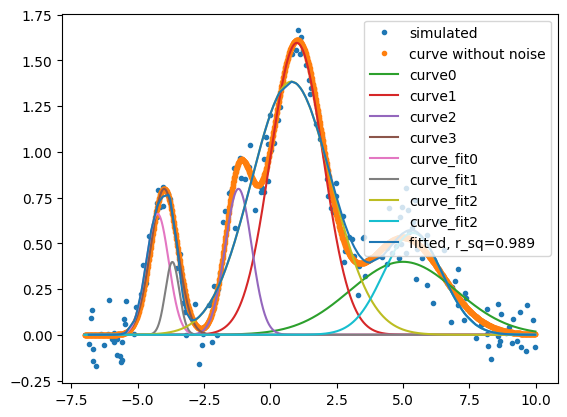

r squared value = 0.989


In [223]:
# Here we do not pass it a 
popt, pcov = curve_fit(curve_to_fit, x_final, y_final)
m0, std0, wt0, m1, std1, wt1, m2, std2, wt2, m3, std3, wt3 = popt
yfit = curve_to_fit(x_final, *popt)
plot_helper()
plot_helper_single_curve(curve_generator([m0], [std0], [wt0]), x, "curve_fit0")
plot_helper_single_curve(curve_generator([m1], [std1], [wt1]), x, "curve_fit1")
plot_helper_single_curve(curve_generator([m2], [std2], [wt2]), x, "curve_fit2")
plot_helper_single_curve(curve_generator([m3], [std3], [wt3]), x, "curve_fit2")

rsq = r_square(y_final, yfit)

plt.plot(x_final, yfit, label=f"fitted, r_sq={rsq:.3f}")
plt.legend()
plt.show()

print(f'r squared value = {rsq:.3f}')

## Unknown number of peaks

Finally we consider the case where the number of peaks is unknown. Here we cycle through a number of guesses of how many peaks there are, and choose num_peaks as the model that gives best r^2 values

fitting 1
fitting 2
fitting 3
fitting 4
fitting 5
fitting 6


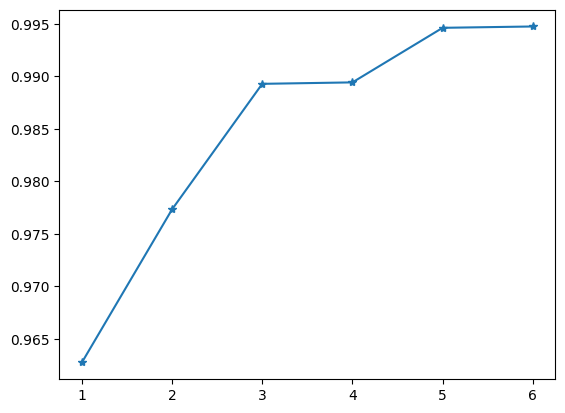

[0.9627631933112738, 0.9773335029284823, 0.9892765728438464, 0.9894145450133895, 0.9946066644724743, 0.9947340637501773]


In [217]:
optimized_params = []
rsqs = []
yfits = []
for n_component in range(1,7):
    print('fitting', n_component)
    curve_to_fit = create_curve_to_fit(n_component)
    popt, pcov = curve_fit(curve_to_fit, x_final, y_final, maxfev=100000)
    yfit = curve_to_fit(x_final, *popt)
    rsq = r_square(y_final, yfit)
    yfits += [yfit]
    optimized_params += [popt]
    rsqs += [rsq]


plt.plot(range(1,7), rsqs, '*-')
plt.show()
print(rsqs)



In general we expect the r^2 value to increase as we increase. However if we choose number of components = 1, we get underfitting

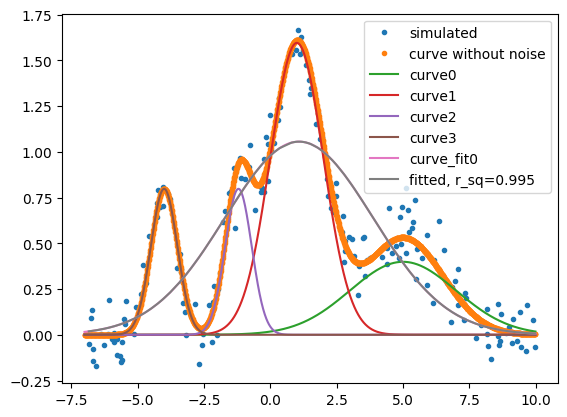

In [218]:

plot_helper()
plot_helper_single_curve(curve_generator([optimized_params[0][0]], [optimized_params[0][1]], [optimized_params[0][2]]), x, "curve_fit0")
plt.plot(x_final, yfits[0], label=f"fitted, r_sq={rsq:.3f}")
plt.legend()
plt.show()

On the other hand if we choose a large number of components (say 7) we might overfit. For example, it detects a small spurious peak near -2.5 

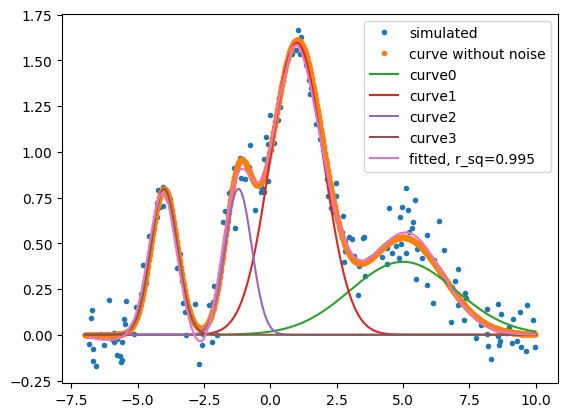

In [220]:
plot_helper()

n = 7

#for i in range(n):
#    plot_helper_single_curve(curve_generator([optimized_params[i][0]], [optimized_params[i][1]], [optimized_params[i][2]]), x, f"curve_fit{i}")
plt.plot(x_final, yfits[5], label=f"fitted, r_sq={rsq:.3f}")
plt.legend()
plt.show()

Another possibility is to use GMM and fit the curve like [this](https://stackoverflow.com/questions/55187037/how-can-i-do-a-histogram-with-1d-gaussian-mixture-with-sklearn)